### Imports

In [1]:
import os
import json
import string
import itertools
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from sdv.metadata import Metadata
from sdv.sequential import PARSynthesizer

from simulation.simulation_tools import get_optimal_sim_XY, run_detection_metrics, run_detection_metrics_XY, prepare_det_data
from simulation.simulation_metrics import mmd_torch

import sys
import warnings
import numpy as np
import pandas as pd

from CausalTime.tools import generate_CT

from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import TimeSeriesDataLoader
warnings.filterwarnings("ignore")

COL_NAMES = list(string.ascii_uppercase) + ["".join(a) for a in list(itertools.permutations(list(string.ascii_uppercase), r=2))]

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Data & Comparison

In [3]:
par_dir = Path(os.getcwd()).parents[1].as_posix() 
FN = "cp_style"

# Data structure as such for convenient comparison with CausalTime
DATA_DICT = {
    # # # NOTE: uncomment for MvTS real data
    # filename.split(".csv")[0]: {
    #     'data_path': f"{par_dir}/data/MvTS/{FN}/",
    #     'data_type': 'fmri',
    #     'task': filename, 
    #     'straight_path': f"{par_dir}/data/MvTS/{FN}/" + f"{filename}"
    # } for filename in os.listdir(f"{par_dir}/data/MvTS/{FN}/")

    # # NOTE: uncomment for the fMRI data
    # filename.split(".csv")[0]: {
    #     'data_path': f"{par_dir}/data/{FN}/timeseries/",
    #     'data_type': 'fmri',
    #     'task': filename, 
    #     'straight_path': f"{par_dir}/data/{FN}/timeseries/" + f"{filename}"
    # } for filename in os.listdir(f"{par_dir}/data/{FN}/timeseries/")

    # # NOTE: uncomment for custom synthetic data
    # filename.split(".csv")[0]: {
    #     'data_path': f"{par_dir}/data/{FN}/increasing_edges_cp_1/data/",
    #     'data_type': 'fmri',
    #     'task': filename, 
    #     'straight_path': f"{par_dir}/data/{FN}/increasing_edges_cp_1/data/" + f"{filename}"
    # } for filename in os.listdir(f"{par_dir}/data/{FN}/increasing_edges_cp_1/data/")[:]

    # NOTE: uncomment for custom synthetic data
    filename.split(".csv")[0]: {
        'data_path': f"{par_dir}/data/{FN}/cp_0_L_1L+/data/",
        'data_type': 'fmri',
        'task': filename, 
        'straight_path': f"{par_dir}/data/{FN}/cp_0_L_1L+/data/" + f"{filename}"
    } for filename in os.listdir(f"{par_dir}/data/{FN}/cp_0_L_1L+/data/")[:]
}

# CausalTime Parameters
PARAMS = {
    "batch_size" : 32, 
    "hidden_size" : 128, 
    "num_layers" : 2, 
    "dropout" : 0.1, 
    "seq_length" : 20, 
    "test_size" : 0.2, 
    "learning_rate" : 0.0001, 
    "n_epochs" : 1, 
    "flow_length" : 4, 
    "gen_n" : 20, 
    "n" : 2000,
    "arch_type" : "LSTM", 
    "save_path" : "outputs/", 
    "log_dir" : "log/", 
}

# Placeholders
det_dict = {}
auc_dict_tcs = {}
data_dict_tcs = {}
auc_dict_ct = {}
data_dict_ct = {}
auc_dict_sdv = {}
data_dict_sdv = {}
auc_dict_tvae = {}
data_dict_tvae = {}

mmd_dict_tcs = {}
mmd_dict_ct = {}
mmd_dict_sdv = {}
mmd_dict_tvae = {}

for k, v in list(DATA_DICT.items())[:]:

    try:
    
        # info
        filename = v['task']
        print(f" \n------------- {filename} ---------------\n ")

        # data
        true_data = pd.read_csv(v["straight_path"])
        true_data = true_data.rename(columns=dict(zip(true_data.columns, COL_NAMES[:true_data.shape[1]])))
        
        # adjust timesteps for computation time (1000 max)
        print(f"true data length: {true_data.shape[0]}")

        if true_data.shape[0]>2000:
            anchor = np.random.uniform(low=0, high=true_data.shape[0]-2000)
            true_data = true_data.loc[anchor : anchor + 2000, :]
            print(f"true data length (adjusted): {true_data.shape[0]}")

        for i in range(true_data.shape[0]):
            for j in range(true_data.shape[1]):
                if true_data.iloc[i, j] == 0:
                    true_data.iloc[i, j] += np.random.uniform(low=0.0001, high=0.001)
        

        """ ____________________________________ Simulate w/ TCS ____________________________________ """

        results_tcs = get_optimal_sim_XY(true_data=true_data, sparsity_penalty=True)
        tcs_data = results_tcs["optimal_data"]
        tcs_auc = results_tcs["auc"]

        """ Get optimal det & config """
        optimal_det_config = results_tcs["optimal_detector_config"]
        optimal_det_func = results_tcs["optimal_detector"]

        # Fix potential length mismatches
        if true_data.shape[0] > tcs_data.shape[0]:
            true_data = true_data[:tcs_data.shape[0]]
        elif true_data.shape[0] < tcs_data.shape[0]:
            tcs_data = tcs_data[:true_data.shape[0]]

        # Evaluate
        print(f"LOG : true shape - {true_data.shape} VS tcs shape - {tcs_data.shape}")
        # train_X, train_Y, test_X, test_Y = prepare_det_data(real=true_data, synthetic=tcs_data)
        # tcs_auc = run_detection_metrics_XY(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y)['auc']
        tcs_auc = run_detection_metrics(real=true_data, synthetic=tcs_data)['auc']

        mmd = mmd_torch(synthetic=tcs_data, real=true_data)

        # Store
        mmd_dict_tcs[filename] = mmd
        auc_dict_tcs[filename] = tcs_auc
        data_dict_tcs[filename] = tcs_data.copy()


        print("""\n ____________________________________ Simulate w/ CausalTime ____________________________________ \n""")

        true_pd, pro_true_pd, skimmed_pd, pro_gen_pd = generate_CT(
                batch_size=PARAMS["batch_size"], 
                hidden_size=PARAMS["hidden_size"], 
                num_layers=PARAMS["num_layers"], 
                dropout=PARAMS["dropout"], 
                seq_length=PARAMS["seq_length"], 
                test_size=PARAMS["test_size"], 
                learning_rate=PARAMS["learning_rate"], 
                n_epochs=PARAMS["n_epochs"], 
                flow_length=PARAMS["flow_length"], 
                gen_n=PARAMS["gen_n"], 
                n=PARAMS["n"],
                arch_type=PARAMS["arch_type"], 
                save_path=PARAMS["save_path"], 
                log_dir=PARAMS["log_dir"], 
                data_path=v["data_path"],
                data_type= v["data_type"], 
                task= v["task"],
            )
        ct_data = pro_gen_pd.copy()

        # Fix potential length mismatches
        if true_data.shape[0] > ct_data.shape[0]:
            true_data = true_data[:ct_data.shape[0]]
        elif true_data.shape[0] < ct_data.shape[0]:
            ct_data = ct_data[:true_data.shape[0]]

        # Evaluate
        print(f"LOG : true shape - {true_data.shape} VS ct shape - {ct_data.shape}")
        # train_X, train_Y, test_X, test_Y = prepare_det_data(real=true_data, synthetic=ct_data)
        # ct_auc = run_detection_metrics_XY(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y)['auc']
        ct_auc = run_detection_metrics(real=true_data, synthetic=ct_data)['auc']

        mmd = mmd_torch(synthetic=ct_data, real=true_data)

        # Store
        mmd_dict_ct[filename] = mmd
        auc_dict_ct[filename] = ct_auc
        data_dict_ct[filename] = ct_data.copy()


        print("""\n ____________ Simulate w/ SDV ____________ \n""")

        true_data_sdv = true_data.copy()

        # Creating same conditions as CausalTime
        els = true_data_sdv.shape[0] % (true_data_sdv.shape[0]//20)
        if els!=0:
            true_data_sdv = true_data_sdv.iloc[:-els, :]

        # Sequence key
        true_data_sdv.loc[:, 'id'] = [i for i in range(true_data_sdv.shape[0]//20) for _ in range(20)]

        # Metadata
        metadata = Metadata.detect_from_dataframe(data=true_data_sdv)
        metadata.tables["table"].columns["id"]["sdtype"] = "id"
        metadata.set_sequence_key(column_name='id')

        # Synthesizer
        synthesizer = PARSynthesizer(metadata)
        synthesizer.fit(data=true_data_sdv)
        synthetic_data = synthesizer.sample(num_sequences=true_data_sdv.shape[0]//20 + 1)

        # Fix potential length mismatches
        sdv_data = synthetic_data.loc[:len(true_data), :].drop(columns=["id"])
        if true_data.shape[0] > sdv_data.shape[0]:
            true_data = true_data[:sdv_data.shape[0]]
        elif true_data.shape[0] < sdv_data.shape[0]:
            sdv_data = sdv_data[:true_data.shape[0]]
        
        mmd = mmd_torch(synthetic=sdv_data, real=true_data)

        # Evaluate
        print(f"LOG : true shape - {true_data.shape} VS sdv shape - {sdv_data.shape}")
        train_X, train_Y, test_X, test_Y = prepare_det_data(real=true_data, synthetic=sdv_data)
        sdv_auc = run_detection_metrics_XY(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y)['auc']

        # Store
        mmd_dict_sdv[filename] = mmd
        auc_dict_sdv[filename] = sdv_auc
        data_dict_sdv[filename] = sdv_data.copy()


        print("""\n _____________ Simulate w/ TimeVAE _____________ \n""")
        
        # Prepare TimeVAE Data
        dat = true_data.copy()

        n_samples = dat.shape[0]
        if 'target' in dat.columns:
            X = dat.drop(columns=['target']) 
            y = dat['target'] 
        else:
            X = dat
            y = None

        temporal_data = [X]
        observation_times = [X.index.to_numpy()]

        # Initialize the TimeSeriesDataLoader
        X_loader = TimeSeriesDataLoader(
            temporal_data=temporal_data, 
            observation_times=observation_times, 
            outcome=y,
            static_data=None,
            train_size=1.0, 
            test_size=0.0
        )

        # Define plugin kwargs for TimeVAE
        plugin_kwargs = dict(
            n_iter=30,
            batch_size=64,
            lr=0.001,
            encoder_n_layers_hidden=2,
            decoder_n_layers_hidden=2,
            encoder_dropout=0.05,
            decoder_dropout=0.05
        )

        # Initialize the generative model for TimeVAE
        test_plugin = Plugins().get("tvae", **plugin_kwargs)
        # test_plugin = Plugins().get("timegan", ?)

        # Fit the model
        if y is not None:
            test_plugin.fit(X_loader, cond=y)
        else:
            test_plugin.fit(X_loader)

        # Generate synthetic data
        generated_data = test_plugin.generate(count=n_samples) 

        # Extract the generated time-series data
        generated_data = generated_data.data["seq_data"]

        # Drop unnecessary columns like "seq_id", "seq_time_id"
        generated_data = generated_data.drop(columns=["seq_id", "seq_time_id"])

        # Fix potential length mismatches
        if true_data.shape[0] > generated_data.shape[0]:
            true_data = true_data[:generated_data.shape[0]]
        elif true_data.shape[0] < generated_data.shape[0]:
            generated_data = generated_data[:true_data.shape[0]]

        # Evaluate TimeVAE generated data
        print(f"LOG : true shape - {true_data.shape} VS generated shape - {generated_data.shape}")
        train_X, train_Y, test_X, test_Y = prepare_det_data(real=true_data, synthetic=generated_data)
        tvae_auc = run_detection_metrics_XY(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y)['auc']

        mmd = mmd_torch(synthetic=generated_data, real=dat)

        # Store results for TimeVAE
        mmd_dict_tvae[filename] = mmd
        auc_dict_tvae[filename] = tvae_auc
        data_dict_tvae[filename] = generated_data.copy()
    
    except:
        print(f"  ========================= ERROR OCCURED ========================= ")
        continue

 
------------- cp_collection_data_0.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 90.51it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 26.03it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.46 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 2.02 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 102.91it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 28.53it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.42 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.37 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1005.29it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 104.60it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 14.94it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9996747967479674 (auc) || configs: 12 || elapsed_time: 0.81 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.41 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9723389830508475
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 919.96it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 96.00it/s] 


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 28.10it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.43 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.51 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1076.84it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 94.09it/s] 


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 23.97it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.5 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.37 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 987.18it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 93.36it/s] 


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 26.67it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.45 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9998016922263353
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:10<00:00, 48.96it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.34it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.999869918699187 (auc) || configs: 12 || elapsed_time: 2.25 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 3.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9640921409214093
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:07<00:00, 68.80it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.36it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 1.29 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.57 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9999338974087785
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 718.64it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 89.17it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 13.68it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.88 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.61 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 883.39it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 91.81it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 13.54it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.89 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.63 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 957.22it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 94.36it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 18.59it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.65 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 937.92it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 96.47it/s] 


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 18.79it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.64 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.81 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=6 | auc=0.9640921409214093 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 364.92it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=1.0 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 477.31it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=1.0 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 497.51it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.9723389830508475 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 480.69it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=1.0 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 404.87it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=4 | auc=1.0 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 508.93it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=5 | auc=0.9998016922263353 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 503.74it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=7 | auc=0.9999338974087785 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 500.00it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=8 | auc=1.0 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 485.36it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=9 | auc=1.0 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 507.62it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=10 | auc=1.0 | edges=10.0


100%|██████████| 100/100 [00:00<00:00, 500.00it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=11 | auc=1.0 | edges=10.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=6 | auc=0.9640921409214093 | edges=10.0
LOG: Optimal Simulation (0.9640921409214093 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": {
            "n_lags": 2,
            "n_reps": 10
        },
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "n_estimators": 500
        },
        "pred_method": "GBR"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
LOG : true shape - (500, 15) VS tcs shape - (500, 15)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 11.56it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.999869918699187 (auc) || configs: 12 || elapsed_time: 1.04 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 2.05 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 15]),y_shape:torch.Size([32, 15])
Training Full Model...
Epoch 1/1, Train Loss: 0.34313764919837314
Epoch 1/1, Val Loss: 0.3084299862384796
Training Masked Model...
Epoch 1/1, Train Loss: 0.3140138064821561
Epoch 1/1, Val Loss: 0.2887539863586426
Training NF Residual Model...
Epoch 1/5, Loss: 0.2740
Epoch 2/5, Loss: 0.0389
Epoch 3/5, Loss: 0.0206
Epoch 4/5, Loss: 0.0130
Epoch 5/5, Loss: 0.0097
Generating data...
LOG : true shape - (500, 15) VS ct shape - (500, 15)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8295284552845529 (auc) || configs: 12 || elapsed_time: 5.13 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 2.66 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 15) VS sdv shape - (500, 15)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  7.32it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9619815668202765 (auc) || configs: 12 || elapsed_time: 1.64 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5258591925258591 (auc) || configs: 8 || elapsed_time: 5.65 (s)

 _____________ Simulate w/ TimeVAE _____________ 



[2025-10-30T11:33:29.053406+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
100%|██████████| 30/30 [00:10<00:00,  2.75it/s]


LOG : true shape - (500, 15) VS generated shape - (500, 15)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8469022017409115 (auc) || configs: 12 || elapsed_time: 1.46 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.49214760574236444 (auc) || configs: 8 || elapsed_time: 5.29 (s)
 
------------- cp_collection_data_1.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 111.41it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  6.04it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9185040650406504 (auc) || configs: 12 || elapsed_time: 1.99 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9625654276817067 (auc) || configs: 2 || elapsed_time: 1.73 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8574718872781466
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 133.79it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  6.50it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9106341463414634 (auc) || configs: 12 || elapsed_time: 1.85 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9496972519795062 (auc) || configs: 2 || elapsed_time: 1.74 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8582949308755761
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1077.40it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 117.85it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.34it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8137235772357724 (auc) || configs: 12 || elapsed_time: 2.77 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8830645161290323 (auc) || configs: 2 || elapsed_time: 1.92 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.43132510013351133
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1195.05it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 135.97it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.27it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7015934959349593 (auc) || configs: 12 || elapsed_time: 3.67 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


LOG: Optimal Detection Config: lstm_discrimination: 0.8415343915343916 (auc) || configs: 2 || elapsed_time: 2.25 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5726101694915254
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1165.31it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 139.30it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6202276422764228 (auc) || configs: 12 || elapsed_time: 3.41 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8371242594895049 (auc) || configs: 2 || elapsed_time: 1.7 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5314586114819759
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1189.24it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 140.12it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.21it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7639674796747967 (auc) || configs: 12 || elapsed_time: 2.85 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.927956435352123 (auc) || configs: 2 || elapsed_time: 1.6 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4848181514848182
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 132.41it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  6.41it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9251382113821138 (auc) || configs: 12 || elapsed_time: 1.88 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9830597014925373 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.49516263552960804
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 117.64it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  6.57it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9324878048780487 (auc) || configs: 12 || elapsed_time: 1.83 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9951559633027522 (auc) || configs: 2 || elapsed_time: 1.78 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5141784820683902
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1096.49it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 125.45it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8700813008130082 (auc) || configs: 12 || elapsed_time: 2.38 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9442082111436951 (auc) || configs: 2 || elapsed_time: 1.73 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5065954249457338
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1116.62it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 124.15it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.32it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8119024390243902 (auc) || configs: 12 || elapsed_time: 2.78 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8914141414141413 (auc) || configs: 2 || elapsed_time: 1.72 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5098464619492656
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1079.94it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 125.68it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.80it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8147642276422764 (auc) || configs: 12 || elapsed_time: 2.51 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9375410913872452 (auc) || configs: 2 || elapsed_time: 1.67 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.46303404539385845
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1098.10it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 114.42it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.49it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7954471544715447 (auc) || configs: 12 || elapsed_time: 2.68 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8380750383968405 (auc) || configs: 2 || elapsed_time: 1.64 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5531276063386156
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=6 | auc=0.49516263552960804 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 492.61it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.43132510013351133 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 481.78it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.5726101694915254 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 494.16it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=4 | auc=0.5314586114819759 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 483.97it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=5 | auc=0.4848181514848182 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 444.44it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=7 | auc=0.5141784820683902 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 421.88it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=8 | auc=0.5065954249457338 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 483.01it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=9 | auc=0.5098464619492656 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 478.53it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=10 | auc=0.46303404539385845 | edges=3.0


100%|██████████| 100/100 [00:00<00:00, 489.45it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=11 | auc=0.5531276063386156 | edges=3.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=6 | auc=0.49516263552960804 | edges=3.0
LOG: Optimal Simulation (0.49516263552960804 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": {
            "n_lags": 2,
            "n_reps": 10
        },
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "n_estimators": 500
        },
        "pred_method": "GBR"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
LOG : true shape - (500, 12) VS tcs shape - (500, 12)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  6.39it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9252032520325203 (auc) || configs: 12 || elapsed_time: 1.88 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9736911686938129 (auc) || configs: 2 || elapsed_time: 1.64 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 12]),y_shape:torch.Size([32, 12])
Training Full Model...
Epoch 1/1, Train Loss: 0.04431833606213331
Epoch 1/1, Val Loss: 0.03935704380273819
Training Masked Model...
Epoch 1/1, Train Loss: 0.016567159599314134
Epoch 1/1, Val Loss: 0.017207304015755653
Training NF Residual Model...
Epoch 1/5, Loss: 0.0453
Epoch 2/5, Loss: 0.0099
Epoch 3/5, Loss: 0.0056
Epoch 4/5, Loss: 0.0042
Epoch 5/5, Loss: 0.0028
Generating data...
LOG : true shape - (500, 12) VS ct shape - (500, 12)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.84it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7905040650406504 (auc) || configs: 12 || elapsed_time: 2.48 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.61 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 12) VS sdv shape - (500, 12)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  8.03it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7331349206349207 (auc) || configs: 12 || elapsed_time: 1.5 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]
[2025-10-30T11:38:53.812926+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py


LOG: Optimal Detection Config: lstm_detection_XY: 0.5384037401903489 (auc) || configs: 8 || elapsed_time: 5.26 (s)

 _____________ Simulate w/ TimeVAE _____________ 



100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


LOG : true shape - (500, 12) VS generated shape - (500, 12)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  8.41it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5983742959549412 (auc) || configs: 12 || elapsed_time: 1.43 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5601635514018692 (auc) || configs: 8 || elapsed_time: 5.31 (s)
 
------------- cp_collection_data_2.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 148.12it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 37.55it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.32 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.9 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 158.78it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 37.03it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.33 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.7 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 791.91it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 159.11it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 25.72it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.47 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.78 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 773.96it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 160.85it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 27.01it/s]


LOG: Optimal Detection Config: svm_detection_XY: 1.0 (auc) || configs: 12 || elapsed_time: 0.45 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.78 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 906.85it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 179.27it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.43it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9836747967479674 (auc) || configs: 12 || elapsed_time: 1.28 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9972231404958677 (auc) || configs: 2 || elapsed_time: 1.76 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8518292682926829
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 781.42it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 157.00it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 26.76it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.99869918699187 (auc) || configs: 12 || elapsed_time: 0.45 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.77 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4284403669724771
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 149.18it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.65it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9975284552845529 (auc) || configs: 12 || elapsed_time: 1.25 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.82 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8407181571815718
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 167.37it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 10.32it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9991544715447154 (auc) || configs: 12 || elapsed_time: 1.17 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.71 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8803876389265384
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 786.34it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 159.27it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 11.20it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9980487804878049 (auc) || configs: 12 || elapsed_time: 1.08 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9994703389830508 (auc) || configs: 2 || elapsed_time: 1.61 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8821138211382114
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 916.36it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 181.18it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 11.12it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9955772357723577 (auc) || configs: 12 || elapsed_time: 1.08 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9908730158730158 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 1.0
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 886.17it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 180.27it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 11.28it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9947317073170732 (auc) || configs: 12 || elapsed_time: 1.07 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9965572033898304 (auc) || configs: 2 || elapsed_time: 1.67 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9033197831978319
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 909.75it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 182.51it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 10.87it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9964227642276423 (auc) || configs: 12 || elapsed_time: 1.11 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9983471074380165 (auc) || configs: 2 || elapsed_time: 1.81 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8815878607234792
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=5 | auc=0.4284403669724771 | edges=7.0


100%|██████████| 100/100 [00:00<00:00, 493.86it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=5 | auc=0.4284403669724771 | edges=7.0
LOG: Optimal Simulation (0.4284403669724771 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "dilation_c": 2,
            "epochs": 1000,
            "kernel_size": 2,
            "lr": 0.01,
            "num_levels": 0
        },
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "spline"
    },
    "z": {
        "noise_approximation": "spline"
    }
}
LOG : true shape - (500, 7) VS tcs shape - (500, 7)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 27.03it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.99869918699187 (auc) || configs: 12 || elapsed_time: 0.45 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.62 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 7]),y_shape:torch.Size([32, 7])
Training Full Model...
Epoch 1/1, Train Loss: 0.22075650840997696
Epoch 1/1, Val Loss: 0.18512924015522003
Training Masked Model...
Epoch 1/1, Train Loss: 0.19018404434124628
Epoch 1/1, Val Loss: 0.15586529672145844
Training NF Residual Model...
Epoch 1/5, Loss: 0.2235
Epoch 2/5, Loss: 0.0362
Epoch 3/5, Loss: 0.0236
Epoch 4/5, Loss: 0.0162
Epoch 5/5, Loss: 0.0127
Generating data...
LOG : true shape - (500, 7) VS ct shape - (500, 7)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  8.22it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8424065040650407 (auc) || configs: 12 || elapsed_time: 1.46 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.51 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 7) VS sdv shape - (500, 7)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 12.45it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9516769073220686 (auc) || configs: 12 || elapsed_time: 0.97 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]
[2025-10-30T11:42:48.370526+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py


LOG: Optimal Detection Config: lstm_detection_XY: 0.5150437373834471 (auc) || configs: 8 || elapsed_time: 5.21 (s)

 _____________ Simulate w/ TimeVAE _____________ 



100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


LOG : true shape - (500, 7) VS generated shape - (500, 7)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 11.01it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8245647721454175 (auc) || configs: 12 || elapsed_time: 1.09 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.49499332443257676 (auc) || configs: 8 || elapsed_time: 5.53 (s)
 
------------- cp_collection_data_3.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 285.35it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 25.92it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9168780487804878 (auc) || configs: 12 || elapsed_time: 0.47 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9298617084629128 (auc) || configs: 2 || elapsed_time: 1.9 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8929006909632841
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 289.00it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 24.55it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9137560975609756 (auc) || configs: 12 || elapsed_time: 0.49 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9641272189349113 (auc) || configs: 2 || elapsed_time: 1.78 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.44965770579395564
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1149.75it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 346.68it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 12.71it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9670243902439024 (auc) || configs: 12 || elapsed_time: 0.95 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8136673258624478 (auc) || configs: 2 || elapsed_time: 1.69 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9751454257006875
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1161.09it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 349.66it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 10.43it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.76669918699187 (auc) || configs: 12 || elapsed_time: 1.15 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7836257309941521 (auc) || configs: 2 || elapsed_time: 1.73 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4587577224912339
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1067.48it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 316.71it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.93it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.919869918699187 (auc) || configs: 12 || elapsed_time: 1.21 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7087321885275849 (auc) || configs: 2 || elapsed_time: 1.93 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9253701745108408
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1029.32it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 310.92it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 11.60it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8539186991869919 (auc) || configs: 12 || elapsed_time: 1.04 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8498794652640806 (auc) || configs: 2 || elapsed_time: 1.76 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8365282919090429
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 354.87it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 22.19it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9203902439024391 (auc) || configs: 12 || elapsed_time: 0.54 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9386919985385458 (auc) || configs: 2 || elapsed_time: 1.66 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5490408673894912
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 359.19it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 21.52it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9072520325203253 (auc) || configs: 12 || elapsed_time: 0.56 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9579557569296377 (auc) || configs: 2 || elapsed_time: 1.77 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8794715447154471
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 797.00it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 339.61it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  8.85it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8269918699186992 (auc) || configs: 12 || elapsed_time: 1.36 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.5574178559575174 (auc) || configs: 2 || elapsed_time: 1.75 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8603913273400319
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 825.35it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 359.41it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 24.35it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9996747967479676 (auc) || configs: 12 || elapsed_time: 0.5 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 2.15 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9626693766937668
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 723.75it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 332.97it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 11.68it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9583739837398374 (auc) || configs: 12 || elapsed_time: 1.03 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7063255998413641 (auc) || configs: 2 || elapsed_time: 1.65 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9639740877842412
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 786.02it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:01<00:00, 334.43it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 13.46it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9506341463414634 (auc) || configs: 12 || elapsed_time: 0.89 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9309309309309308 (auc) || configs: 2 || elapsed_time: 1.75 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9625198307773665
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=3 | auc=0.4587577224912339 | edges=5.0


100%|██████████| 100/100 [00:00<00:00, 409.78it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.44965770579395564 | edges=5.0


100%|██████████| 100/100 [00:00<00:00, 476.18it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=6 | auc=0.5490408673894912 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 348.43it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=6 | auc=0.5490408673894912 | edges=4.0
LOG: Optimal Simulation (0.5490408673894912 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": {
            "n_lags": 2,
            "n_reps": 10
        },
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "n_estimators": 500
        },
        "pred_method": "GBR"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
LOG : true shape - (500, 3) VS tcs shape - (500, 3)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 21.68it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9204552845528456 (auc) || configs: 12 || elapsed_time: 0.56 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9243389731194609 (auc) || configs: 2 || elapsed_time: 1.87 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 3]),y_shape:torch.Size([32, 3])
Training Full Model...
Epoch 1/1, Train Loss: 0.742445836464564
Epoch 1/1, Val Loss: 0.6917849779129028
Training Masked Model...
Epoch 1/1, Train Loss: 0.8400475879510244
Epoch 1/1, Val Loss: 0.7794882655143738
Training NF Residual Model...
Epoch 1/5, Loss: 0.7880
Epoch 2/5, Loss: 0.1724
Epoch 3/5, Loss: 0.0376
Epoch 4/5, Loss: 0.0261
Epoch 5/5, Loss: 0.0156
Generating data...
LOG : true shape - (500, 3) VS ct shape - (500, 3)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.97it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8619186991869918 (auc) || configs: 12 || elapsed_time: 2.01 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.68 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 3) VS sdv shape - (500, 3)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:00<00:00, 13.86it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8223246287762417 (auc) || configs: 12 || elapsed_time: 0.87 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
[2025-10-30T11:45:24.720056+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py


LOG: Optimal Detection Config: lstm_detection_XY: 0.570653987320654 (auc) || configs: 8 || elapsed_time: 5.44 (s)

 _____________ Simulate w/ TimeVAE _____________ 



100%|██████████| 30/30 [00:05<00:00,  5.81it/s]


LOG : true shape - (500, 3) VS generated shape - (500, 3)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00, 11.40it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8230926779313876 (auc) || configs: 12 || elapsed_time: 1.06 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5509846461949265 (auc) || configs: 8 || elapsed_time: 5.76 (s)
 
------------- cp_collection_data_4.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 103.06it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.70it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7766504065040651 (auc) || configs: 12 || elapsed_time: 3.24 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8142304039739938 (auc) || configs: 2 || elapsed_time: 1.92 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4868223519599667
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 95.57it/s] 


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.67it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7977235772357723 (auc) || configs: 12 || elapsed_time: 3.27 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9715809468147283 (auc) || configs: 2 || elapsed_time: 1.9 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5481234361968307
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1126.07it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 116.31it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.78it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8762276422764228 (auc) || configs: 12 || elapsed_time: 2.08 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9126322751322751 (auc) || configs: 2 || elapsed_time: 1.65 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8582949308755761
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1167.36it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 115.98it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.86it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7982439024390244 (auc) || configs: 12 || elapsed_time: 2.47 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.913135593220339 (auc) || configs: 2 || elapsed_time: 1.71 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5109641781051222
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1118.55it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 117.48it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.89it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6351219512195122 (auc) || configs: 12 || elapsed_time: 3.09 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.6936204497180107 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4953286619953287
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1182.13it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 114.42it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  6.03it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.880910569105691 (auc) || configs: 12 || elapsed_time: 1.99 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9389145242803779 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5678744364668559
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 110.76it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9899837398373983 (auc) || configs: 12 || elapsed_time: 2.44 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5551292743953293
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 105.65it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.27it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9946666666666667 (auc) || configs: 12 || elapsed_time: 2.81 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9916420118343194 (auc) || configs: 2 || elapsed_time: 1.59 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9966948704389211
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1282.20it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 125.71it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.95it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9723577235772358 (auc) || configs: 12 || elapsed_time: 3.04 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9934597295708407 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4087116154873164
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1274.80it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 124.10it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.93it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9735934959349593 (auc) || configs: 12 || elapsed_time: 2.03 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9475452951490357 (auc) || configs: 2 || elapsed_time: 1.6 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9586197778952934
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1248.05it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 123.97it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.28it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.975869918699187 (auc) || configs: 12 || elapsed_time: 2.8 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9936801881246325 (auc) || configs: 2 || elapsed_time: 1.64 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5485890799799632
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1250.08it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 118.09it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9693008130081301 (auc) || configs: 12 || elapsed_time: 2.37 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9240839610912016 (auc) || configs: 2 || elapsed_time: 1.79 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9527366472765733
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=4 | auc=0.4953286619953287 | edges=9.0


100%|██████████| 100/100 [00:00<00:00, 427.30it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.4868223519599667 | edges=9.0


100%|██████████| 100/100 [00:00<00:00, 469.40it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.5481234361968307 | edges=9.0


100%|██████████| 100/100 [00:00<00:00, 504.29it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.5109641781051222 | edges=9.0


100%|██████████| 100/100 [00:00<00:00, 494.95it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=5 | auc=0.5678744364668559 | edges=9.0


100%|██████████| 100/100 [00:00<00:00, 464.60it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=6 | auc=0.5551292743953293 | edges=9.0


100%|██████████| 100/100 [00:00<00:00, 465.12it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=8 | auc=0.4087116154873164 | edges=9.0


100%|██████████| 100/100 [00:00<00:00, 483.09it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=10 | auc=0.5485890799799632 | edges=9.0


100%|██████████| 100/100 [00:00<00:00, 434.78it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=4 | auc=0.4953286619953287 | edges=9.0
LOG: Optimal Simulation (0.4953286619953287 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "dilation_c": 2,
            "epochs": 1000,
            "kernel_size": 2,
            "lr": 0.01,
            "num_levels": 0
        },
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
LOG : true shape - (500, 11) VS tcs shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.90it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6349918699186993 (auc) || configs: 12 || elapsed_time: 3.08 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7052839578454333 (auc) || configs: 2 || elapsed_time: 1.78 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 11]),y_shape:torch.Size([32, 11])
Training Full Model...
Epoch 1/1, Train Loss: 0.36481187492609024
Epoch 1/1, Val Loss: 0.33600297570228577
Training Masked Model...
Epoch 1/1, Train Loss: 0.31656978527704877
Epoch 1/1, Val Loss: 0.3080045282840729
Training NF Residual Model...
Epoch 1/5, Loss: 0.3161
Epoch 2/5, Loss: 0.0444
Epoch 3/5, Loss: 0.0197
Epoch 4/5, Loss: 0.0127
Epoch 5/5, Loss: 0.0098
Generating data...
LOG : true shape - (500, 11) VS ct shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8042926829268293 (auc) || configs: 12 || elapsed_time: 2.42 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.75 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 11) VS sdv shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.19it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8280849974398361 (auc) || configs: 12 || elapsed_time: 1.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.6004810004810004 (auc) || configs: 8 || elapsed_time: 5.18 (s)

 _____________ Simulate w/ TimeVAE _____________ 



[2025-10-30T11:51:00.447154+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


LOG : true shape - (500, 11) VS generated shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.25it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7386072708653353 (auc) || configs: 12 || elapsed_time: 1.3 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5447538298487331 (auc) || configs: 8 || elapsed_time: 5.02 (s)
 
------------- cp_collection_data_5.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 156.13it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.01it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6386341463414634 (auc) || configs: 12 || elapsed_time: 3.0 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.5684628099173553 (auc) || configs: 2 || elapsed_time: 1.84 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6378239026969857
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 168.22it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.07it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5376910569105691 (auc) || configs: 12 || elapsed_time: 2.95 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7740046838407494 (auc) || configs: 2 || elapsed_time: 1.81 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.46096747289407836
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1274.99it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 174.31it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.06it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5443577235772358 (auc) || configs: 12 || elapsed_time: 2.96 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7192546583850932 (auc) || configs: 2 || elapsed_time: 1.63 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5316930775646374
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1255.11it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 174.67it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5311869918699186 (auc) || configs: 12 || elapsed_time: 2.87 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7699147560258671 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5177944862155388
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1274.47it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 175.64it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.27it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5 (auc) || configs: 12 || elapsed_time: 2.81 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8039473684210526 (auc) || configs: 2 || elapsed_time: 1.63 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4540373707040374
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1247.44it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 172.10it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.13it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5188292682926828 (auc) || configs: 12 || elapsed_time: 2.91 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7100379894798364 (auc) || configs: 2 || elapsed_time: 1.66 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5437103770437104
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 157.19it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.09it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.787609756097561 (auc) || configs: 12 || elapsed_time: 2.93 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9299386323787259 (auc) || configs: 2 || elapsed_time: 1.75 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5139352469959946
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 154.56it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.96it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.737040650406504 (auc) || configs: 12 || elapsed_time: 3.03 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


LOG: Optimal Detection Config: lstm_discrimination: 0.9156697247706421 (auc) || configs: 2 || elapsed_time: 2.04 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5341459342127234
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1255.86it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 174.59it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.77it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7319674796747968 (auc) || configs: 12 || elapsed_time: 3.19 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9144298983397938 (auc) || configs: 2 || elapsed_time: 1.72 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5262850467289719
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1281.16it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 174.80it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.41it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6668943089430894 (auc) || configs: 12 || elapsed_time: 2.72 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.615909090909091 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6645293495505024
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1286.62it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:02<00:00, 178.03it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.22it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7819837398373983 (auc) || configs: 12 || elapsed_time: 2.85 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.6309968505090457 (auc) || configs: 2 || elapsed_time: 1.64 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6436409307244844
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1020.91it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 158.00it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.14it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7452357723577236 (auc) || configs: 12 || elapsed_time: 2.9 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8447368421052632 (auc) || configs: 2 || elapsed_time: 1.86 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5094245204336948
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=11 | auc=0.5094245204336948 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 429.12it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.6378239026969857 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 502.42it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.46096747289407836 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 481.55it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.5316930775646374 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 481.71it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.5177944862155388 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 490.20it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=4 | auc=0.4540373707040374 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 497.54it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=5 | auc=0.5437103770437104 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 461.71it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=6 | auc=0.5139352469959946 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 504.97it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=7 | auc=0.5341459342127234 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 436.62it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=8 | auc=0.5262850467289719 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 436.68it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=11 | auc=0.5094245204336948 | edges=2.0
LOG: Optimal Simulation (0.5094245204336948 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": {
            "n_lags": 2,
            "n_reps": 10
        },
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "dilation_c": 2,
            "epochs": 1000,
            "kernel_size": 2,
            "lr": 0.01,
            "num_levels": 0
        },
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "spline"
    },
    "z": {
        "noise_approximation": "spline"
    }
}
LOG : true shape - (500, 10) VS tcs shape - (500, 10)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.11it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7452032520325204 (auc) || configs: 12 || elapsed_time: 2.92 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7207773232028054 (auc) || configs: 2 || elapsed_time: 1.68 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 10]),y_shape:torch.Size([32, 10])
Training Full Model...
Epoch 1/1, Train Loss: 0.2701656445860863
Epoch 1/1, Val Loss: 0.23940253257751465
Training Masked Model...
Epoch 1/1, Train Loss: 0.22026160111029944
Epoch 1/1, Val Loss: 0.19172625243663788
Training NF Residual Model...
Epoch 1/5, Loss: 0.2702
Epoch 2/5, Loss: 0.0529
Epoch 3/5, Loss: 0.0317
Epoch 4/5, Loss: 0.0240
Epoch 5/5, Loss: 0.0196
Generating data...
LOG : true shape - (500, 10) VS ct shape - (500, 10)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.67it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8026016260162603 (auc) || configs: 12 || elapsed_time: 2.57 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.55 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 10) VS sdv shape - (500, 10)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.02it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6571940604198668 (auc) || configs: 12 || elapsed_time: 1.33 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.4782274343939248 (auc) || configs: 8 || elapsed_time: 5.01 (s)

 _____________ Simulate w/ TimeVAE _____________ 



[2025-10-30T11:55:30.724526+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
100%|██████████| 30/30 [00:08<00:00,  3.64it/s]


LOG : true shape - (500, 10) VS generated shape - (500, 10)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.16it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6187916026625704 (auc) || configs: 12 || elapsed_time: 1.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5776869158878504 (auc) || configs: 8 || elapsed_time: 5.08 (s)
 
------------- cp_collection_data_6.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 110.33it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.62it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7721951219512195 (auc) || configs: 12 || elapsed_time: 3.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9241505297771282 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4572263993316624
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 119.26it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7680650406504065 (auc) || configs: 12 || elapsed_time: 3.37 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8444444444444444 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5075972616463517
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1172.51it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 130.06it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.68it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.504390243902439 (auc) || configs: 12 || elapsed_time: 3.27 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8223506180062898 (auc) || configs: 2 || elapsed_time: 1.61 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5096763430096763
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1146.79it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 119.86it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.78it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5607154471544715 (auc) || configs: 12 || elapsed_time: 3.18 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.6199809844218533 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.45861148197596796
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1136.15it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 122.41it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.76it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5242926829268293 (auc) || configs: 12 || elapsed_time: 3.2 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8441453960359834 (auc) || configs: 2 || elapsed_time: 1.65 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.47497497497497493
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1117.27it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 120.20it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.63it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5749268292682927 (auc) || configs: 12 || elapsed_time: 3.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.5490887713109935 (auc) || configs: 2 || elapsed_time: 1.66 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6108540454785827
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 123.54it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9841951219512195 (auc) || configs: 12 || elapsed_time: 3.2 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.972435141509434 (auc) || configs: 2 || elapsed_time: 1.75 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.995637228979376
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 123.27it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.85it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9847154471544715 (auc) || configs: 12 || elapsed_time: 3.12 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8287390029325513 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9964965626652564
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1304.87it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 136.36it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.57it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9397723577235773 (auc) || configs: 12 || elapsed_time: 3.36 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7438070880526123 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9185616076150185
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1291.93it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 122.69it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.60it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9342439024390243 (auc) || configs: 12 || elapsed_time: 3.34 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8736119228521333 (auc) || configs: 2 || elapsed_time: 1.62 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.879990745637229
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1245.97it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 134.87it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.73it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9397723577235773 (auc) || configs: 12 || elapsed_time: 3.22 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8456424866681276 (auc) || configs: 2 || elapsed_time: 1.58 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8650185087255421
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1249.84it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 133.45it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.71it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9568780487804878 (auc) || configs: 12 || elapsed_time: 3.24 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7994884910485932 (auc) || configs: 2 || elapsed_time: 1.58 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9379296668429402
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=1 | auc=0.5075972616463517 | edges=7.0


100%|██████████| 100/100 [00:00<00:00, 466.12it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.4572263993316624 | edges=7.0


100%|██████████| 100/100 [00:00<00:00, 510.12it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.5096763430096763 | edges=7.0


100%|██████████| 100/100 [00:00<00:00, 500.00it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.45861148197596796 | edges=7.0


100%|██████████| 100/100 [00:00<00:00, 507.53it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=4 | auc=0.47497497497497493 | edges=7.0


100%|██████████| 100/100 [00:00<00:00, 487.88it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=1 | auc=0.5075972616463517 | edges=7.0
LOG: Optimal Simulation (0.5075972616463517 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "n_estimators": 500
        },
        "pred_method": "GBR"
    },
    "o": {
        "noise_approximation": "spline"
    },
    "z": {
        "noise_approximation": "spline"
    }
}
LOG : true shape - (500, 11) VS tcs shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.72it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7677398373983739 (auc) || configs: 12 || elapsed_time: 3.23 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8475828274701968 (auc) || configs: 2 || elapsed_time: 1.64 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 11]),y_shape:torch.Size([32, 11])
Training Full Model...
Epoch 1/1, Train Loss: 0.2532362143198649
Epoch 1/1, Val Loss: 0.22545172274112701
Training Masked Model...
Epoch 1/1, Train Loss: 0.275640790661176
Epoch 1/1, Val Loss: 0.2506727874279022
Training NF Residual Model...
Epoch 1/5, Loss: 0.3000
Epoch 2/5, Loss: 0.0627
Epoch 3/5, Loss: 0.0365
Epoch 4/5, Loss: 0.0284
Epoch 5/5, Loss: 0.0232
Generating data...
LOG : true shape - (500, 11) VS ct shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.12it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7596422764227642 (auc) || configs: 12 || elapsed_time: 2.92 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9912280701754387 (auc) || configs: 2 || elapsed_time: 1.56 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 11) VS sdv shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  8.47it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6464413722478239 (auc) || configs: 12 || elapsed_time: 1.42 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5371142618849041 (auc) || configs: 8 || elapsed_time: 5.1 (s)

 _____________ Simulate w/ TimeVAE _____________ 



[2025-10-30T12:00:58.091520+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


LOG : true shape - (500, 11) VS generated shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  9.20it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6545698924731183 (auc) || configs: 12 || elapsed_time: 1.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5247133635224974 (auc) || configs: 8 || elapsed_time: 5.32 (s)
 
------------- cp_collection_data_7.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 145.41it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.56it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5618861788617887 (auc) || configs: 12 || elapsed_time: 3.37 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.6699355971896955 (auc) || configs: 2 || elapsed_time: 1.82 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5702120554349641
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 155.42it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.68it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6027967479674797 (auc) || configs: 12 || elapsed_time: 3.27 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.4902834599649328 (auc) || configs: 2 || elapsed_time: 1.7 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6619843997884717
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1239.12it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 158.19it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.61it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5440650406504065 (auc) || configs: 12 || elapsed_time: 3.33 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.6518686462371097 (auc) || configs: 2 || elapsed_time: 1.64 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5053377814845705
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1225.33it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 157.78it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5441300813008131 (auc) || configs: 12 || elapsed_time: 3.55 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.6553254437869823 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5210526315789473
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1259.34it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 161.26it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.82it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6038373983739839 (auc) || configs: 12 || elapsed_time: 3.14 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.5274673095185916 (auc) || configs: 2 || elapsed_time: 1.64 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.6498876255949233
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1246.83it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 158.28it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.90it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5447804878048781 (auc) || configs: 12 || elapsed_time: 3.08 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.6393695014662757 (auc) || configs: 2 || elapsed_time: 1.98 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.529024186822352
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 153.14it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.63it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.822439024390244 (auc) || configs: 12 || elapsed_time: 3.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8375220458553793 (auc) || configs: 2 || elapsed_time: 1.64 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.48448448448448456
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 147.58it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.73it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8063739837398374 (auc) || configs: 12 || elapsed_time: 3.22 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.6459285761611343 (auc) || configs: 2 || elapsed_time: 1.65 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8645888418826017
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1197.75it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 162.34it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.58it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7480975609756098 (auc) || configs: 12 || elapsed_time: 3.36 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8790181180596144 (auc) || configs: 2 || elapsed_time: 1.7 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.53345011678345
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1201.87it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 150.22it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.54it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6269268292682926 (auc) || configs: 12 || elapsed_time: 3.4 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7140039447731755 (auc) || configs: 2 || elapsed_time: 1.63 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.47521695594125496
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1217.98it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 160.69it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.22it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6652357723577236 (auc) || configs: 12 || elapsed_time: 3.73 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8440650526160866 (auc) || configs: 2 || elapsed_time: 1.74 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.47237983978638187
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1124.16it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 147.09it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7104715447154472 (auc) || configs: 12 || elapsed_time: 3.49 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9497406676893856 (auc) || configs: 2 || elapsed_time: 1.91 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.44904086738949134
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=2 | auc=0.5053377814845705 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 519.85it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.5702120554349641 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 465.12it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.5210526315789473 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 502.51it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=5 | auc=0.529024186822352 | edges=2.0


100%|██████████| 100/100 [00:00<00:00, 507.54it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=6 | auc=0.48448448448448456 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 468.22it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=8 | auc=0.53345011678345 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 478.47it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=9 | auc=0.47521695594125496 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 504.97it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=10 | auc=0.47237983978638187 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 452.42it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=11 | auc=0.44904086738949134 | edges=4.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=2 | auc=0.5053377814845705 | edges=2.0
LOG: Optimal Simulation (0.5053377814845705 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {},
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
LOG : true shape - (500, 11) VS tcs shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5328780487804878 (auc) || configs: 12 || elapsed_time: 3.55 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7234669811320754 (auc) || configs: 2 || elapsed_time: 1.83 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 11]),y_shape:torch.Size([32, 11])
Training Full Model...
Epoch 1/1, Train Loss: 0.1668707157174746
Epoch 1/1, Val Loss: 0.1421433538198471
Training Masked Model...
Epoch 1/1, Train Loss: 0.14301829288403192
Epoch 1/1, Val Loss: 0.12419330328702927
Training NF Residual Model...
Epoch 1/5, Loss: 0.2031
Epoch 2/5, Loss: 0.0469
Epoch 3/5, Loss: 0.0240
Epoch 4/5, Loss: 0.0195
Epoch 5/5, Loss: 0.0155
Generating data...
LOG : true shape - (500, 11) VS ct shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.01it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7822113821138211 (auc) || configs: 12 || elapsed_time: 3.99 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 2.23 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 11) VS sdv shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  8.19it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.666794674859191 (auc) || configs: 12 || elapsed_time: 1.47 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.4954120787454121 (auc) || configs: 8 || elapsed_time: 5.59 (s)

 _____________ Simulate w/ TimeVAE _____________ 



[2025-10-30T12:06:13.617575+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
100%|██████████| 30/30 [00:10<00:00,  2.79it/s]


LOG : true shape - (500, 11) VS generated shape - (500, 11)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  6.50it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6853878648233487 (auc) || configs: 12 || elapsed_time: 1.85 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5438866942865401 (auc) || configs: 8 || elapsed_time: 6.85 (s)
 
------------- cp_collection_data_8.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:07<00:00, 72.36it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9066016260162602 (auc) || configs: 12 || elapsed_time: 2.28 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9957652352279494 (auc) || configs: 2 || elapsed_time: 1.88 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9201002981837896
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:06<00:00, 75.88it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.36it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9137560975609755 (auc) || configs: 12 || elapsed_time: 2.24 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9944905409890474 (auc) || configs: 2 || elapsed_time: 1.72 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8810975609756098
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 844.41it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:06<00:00, 84.11it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9415284552845529 (auc) || configs: 12 || elapsed_time: 4.44 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.87 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.48140116763969976
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 838.97it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 86.88it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.854959349593496 (auc) || configs: 12 || elapsed_time: 4.49 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9909345518867925 (auc) || configs: 2 || elapsed_time: 1.79 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5066733400066733
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 861.66it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 87.02it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.50it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.819869918699187 (auc) || configs: 12 || elapsed_time: 3.43 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.945394495412844 (auc) || configs: 2 || elapsed_time: 1.86 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5116783450116784
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 809.84it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:06<00:00, 83.91it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7742764227642275 (auc) || configs: 12 || elapsed_time: 4.39 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.917254556143445 (auc) || configs: 2 || elapsed_time: 1.67 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4839866555462886
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:06<00:00, 79.31it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.70it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9637723577235773 (auc) || configs: 12 || elapsed_time: 3.25 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9974214876033058 (auc) || configs: 2 || elapsed_time: 1.72 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8129657228017884
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:06<00:00, 79.25it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.63it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9558373983739837 (auc) || configs: 12 || elapsed_time: 3.31 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9903641679957469 (auc) || configs: 2 || elapsed_time: 1.75 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.793236649498509
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 902.42it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 91.83it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.00it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9167479674796748 (auc) || configs: 12 || elapsed_time: 2.4 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9918505267342477 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8159214092140921
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 903.67it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 86.90it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.920260162601626 (auc) || configs: 12 || elapsed_time: 2.33 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9726468222043443 (auc) || configs: 2 || elapsed_time: 1.72 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4409507923269391
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 931.13it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 91.67it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.08it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9110243902439025 (auc) || configs: 12 || elapsed_time: 2.94 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9675436277102062 (auc) || configs: 2 || elapsed_time: 1.88 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8841149362970995
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:01<00:00, 865.50it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:05<00:00, 90.33it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.53it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.912910569105691 (auc) || configs: 12 || elapsed_time: 2.65 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.986909090909091 (auc) || configs: 2 || elapsed_time: 1.71 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.8967199783139063
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=3 | auc=0.5066733400066733 | edges=13.0


100%|██████████| 100/100 [00:00<00:00, 449.42it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.48140116763969976 | edges=13.0


100%|██████████| 100/100 [00:00<00:00, 464.94it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=4 | auc=0.5116783450116784 | edges=13.0


100%|██████████| 100/100 [00:00<00:00, 468.68it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=5 | auc=0.4839866555462886 | edges=13.0


100%|██████████| 100/100 [00:00<00:00, 459.72it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=7 | auc=0.793236649498509 | edges=12.0


100%|██████████| 100/100 [00:00<00:00, 472.11it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=9 | auc=0.4409507923269391 | edges=12.0


100%|██████████| 100/100 [00:00<00:00, 474.12it/s]


LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=7 | auc=0.793236649498509 | edges=12.0
LOG: Optimal Simulation (0.793236649498509 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": {
            "n_lags": 2,
            "n_reps": 10
        },
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "n_estimators": 500
        },
        "pred_method": "GBR"
    },
    "o": {
        "noise_approximation": "spline"
    },
    "z": {
        "noise_approximation": "spline"
    }
}
LOG : true shape - (500, 15) VS tcs shape - (500, 15)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.05it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9558373983739837 (auc) || configs: 12 || elapsed_time: 2.96 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9854545454545455 (auc) || configs: 2 || elapsed_time: 1.72 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 15]),y_shape:torch.Size([32, 15])
Training Full Model...
Epoch 1/1, Train Loss: 0.3136436666051547
Epoch 1/1, Val Loss: 0.27741092443466187
Training Masked Model...
Epoch 1/1, Train Loss: 0.30312254279851913
Epoch 1/1, Val Loss: 0.2760240137577057
Training NF Residual Model...
Epoch 1/5, Loss: 0.3296
Epoch 2/5, Loss: 0.0370
Epoch 3/5, Loss: 0.0103
Epoch 4/5, Loss: 0.0063
Epoch 5/5, Loss: 0.0050
Generating data...
LOG : true shape - (500, 15) VS ct shape - (500, 15)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:02<00:00,  4.22it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8349918699186992 (auc) || configs: 12 || elapsed_time: 2.84 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.71 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 15) VS sdv shape - (500, 15)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  6.44it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7418714797747056 (auc) || configs: 12 || elapsed_time: 1.87 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5535371011149559 (auc) || configs: 8 || elapsed_time: 5.73 (s)

 _____________ Simulate w/ TimeVAE _____________ 



[2025-10-30T12:13:55.229706+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


LOG : true shape - (500, 15) VS generated shape - (500, 15)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  7.31it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7609767025089605 (auc) || configs: 12 || elapsed_time: 1.64 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5514018691588786 (auc) || configs: 8 || elapsed_time: 6.33 (s)
 
------------- cp_collection_data_9.csv ---------------
 
true data length: 500
LOG: Optimal Simulation: 12 TCS configurations are to be tested ...
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:06<00:00, 85.44it/s] 


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7353170731707317 (auc) || configs: 12 || elapsed_time: 4.3 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


LOG: Optimal Detection Config: lstm_discrimination: 0.8129765395894428 (auc) || configs: 2 || elapsed_time: 2.05 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5820671230589414
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 106.18it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.29it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7333983739837399 (auc) || configs: 12 || elapsed_time: 3.65 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9053185271770894 (auc) || configs: 2 || elapsed_time: 1.71 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5231859883236031
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1135.10it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 107.56it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.24it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6177560975609757 (auc) || configs: 12 || elapsed_time: 3.7 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.945176245492678 (auc) || configs: 2 || elapsed_time: 1.63 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5404571237904571
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1260.98it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 124.57it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.14it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5571056910569105 (auc) || configs: 12 || elapsed_time: 3.82 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9323717712855986 (auc) || configs: 2 || elapsed_time: 1.81 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.535130173564753
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1277.11it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 128.33it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.29it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5789918699186992 (auc) || configs: 12 || elapsed_time: 3.65 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9675058548009368 (auc) || configs: 2 || elapsed_time: 1.64 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5009183503088996
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': None}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1281.55it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 126.85it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5959349593495934 (auc) || configs: 12 || elapsed_time: 3.52 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9325609031491385 (auc) || configs: 2 || elapsed_time: 1.66 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.4971638304971638
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 121.21it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9103414634146342 (auc) || configs: 12 || elapsed_time: 3.51 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.778138026864289 (auc) || configs: 2 || elapsed_time: 1.63 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.9450026441036489
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'GBR', 'pred_kwargs': {'n_estimators': 500}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...
LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 123.62it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.01it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.9230243902439025 (auc) || configs: 12 || elapsed_time: 3.99 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9486411455289305 (auc) || configs: 2 || elapsed_time: 1.71 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5505430242272347
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1281.92it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 129.72it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7504715447154472 (auc) || configs: 12 || elapsed_time: 3.57 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8626233101936427 (auc) || configs: 2 || elapsed_time: 1.95 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5156041388518025
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1310.03it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 129.29it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.21it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7917073170731708 (auc) || configs: 12 || elapsed_time: 3.75 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.7043779481132075 (auc) || configs: 2 || elapsed_time: 1.61 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.689053410893707
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'est'}, 'o': {'noise_approximation': 'est'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1327.85it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:03<00:00, 130.39it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.24it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7710243902439025 (auc) || configs: 12 || elapsed_time: 3.7 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9171545667447306 (auc) || configs: 2 || elapsed_time: 1.59 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.5173564753004005
_____________________________________________________________________________________________________________
_____________________________________________________________________________________________________________
_______________________ {'cd': {'cd_method': 'PCMCI', 'cd_kwargs': {'n_lags': 2, 'n_reps': 10}}, 'fc': {'pred_method': 'TCDF', 'pred_kwargs': {'num_levels': 0, 'epochs': 1000, 'kernel_size': 2, 'dilation_c': 2, 'lr': 0.01}}, 'z': {'noise_approximation': 'spline'}, 'o': {'noise_approximation': 'spline'}} _______________________
LOG : Phase (1) : Causal structure ...
LOG : Phase (2) : Functional Dependencies ...


100%|██████████| 1000/1000 [00:00<00:00, 1275.46it/s]


LOG : Phase (3) : Noise Estimation ...
LOG : Simulation Phase : Ancestral Sampling ...


100%|██████████| 520/520 [00:04<00:00, 126.86it/s]


LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.12it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.8130731707317074 (auc) || configs: 12 || elapsed_time: 3.85 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.8760330578512396 (auc) || configs: 2 || elapsed_time: 1.68 (s)
LOG: Optimal Simulation: Max C2ST AUC achieved: 0.44506595424945733
_____________________________________________________________________________________________________________
LOG: Optimal Simulation: Enforcing sparcity penalty ...
LOG: Optimal Simulation: Sparsity Penalty: optimal case: idx=4 | auc=0.5009183503088996 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 480.69it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=0 | auc=0.5820671230589414 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 354.61it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=1 | auc=0.5231859883236031 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 485.36it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=2 | auc=0.5404571237904571 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 483.37it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=3 | auc=0.535130173564753 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 518.13it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=5 | auc=0.4971638304971638 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 458.53it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=7 | auc=0.5505430242272347 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 466.86it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=8 | auc=0.5156041388518025 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 498.92it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=10 | auc=0.5173564753004005 | edges=4.0


100%|██████████| 100/100 [00:00<00:00, 512.72it/s]


LOG: Optimal Simulation: Sparsity Penalty: eq. found: idx=11 | auc=0.44506595424945733 | edges=4.0
LOG: Optimal Simulation: Sparsity Penalty: opti case: idx=4 | auc=0.5009183503088996 | edges=4.0
LOG: Optimal Simulation (0.5009183503088996 auc): chosen configuration: {
    "cd": {
        "cd_kwargs": null,
        "cd_method": "PCMCI"
    },
    "fc": {
        "pred_kwargs": {
            "dilation_c": 2,
            "epochs": 1000,
            "kernel_size": 2,
            "lr": 0.01,
            "num_levels": 0
        },
        "pred_method": "TCDF"
    },
    "o": {
        "noise_approximation": "est"
    },
    "z": {
        "noise_approximation": "est"
    }
}
LOG : true shape - (500, 13) VS tcs shape - (500, 13)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.5790569105691057 (auc) || configs: 12 || elapsed_time: 3.63 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


LOG: Optimal Detection Config: lstm_discrimination: 0.9820696721311476 (auc) || configs: 2 || elapsed_time: 1.7 (s)

 ____________________________________ Simulate w/ CausalTime ____________________________________ 

Loading Data...
In loader:X_shape:torch.Size([32, 20, 13]),y_shape:torch.Size([32, 13])
Training Full Model...
Epoch 1/1, Train Loss: 0.29665961613257724
Epoch 1/1, Val Loss: 0.2699253559112549
Training Masked Model...
Epoch 1/1, Train Loss: 0.2812319944302241
Epoch 1/1, Val Loss: 0.26391616463661194
Training NF Residual Model...
Epoch 1/5, Loss: 0.2818
Epoch 2/5, Loss: 0.0614
Epoch 3/5, Loss: 0.0298
Epoch 4/5, Loss: 0.0248
Epoch 5/5, Loss: 0.0207
Generating data...
LOG : true shape - (500, 13) VS ct shape - (500, 13)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7592845528455285 (auc) || configs: 12 || elapsed_time: 3.55 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


LOG: Optimal Detection Config: lstm_discrimination: 1.0 (auc) || configs: 2 || elapsed_time: 1.6 (s)

 ____________ Simulate w/ SDV ____________ 

LOG : true shape - (500, 13) VS sdv shape - (500, 13)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  7.92it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.7137416794674859 (auc) || configs: 12 || elapsed_time: 1.52 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


LOG: Optimal Detection Config: lstm_detection_XY: 0.5335447263017357 (auc) || configs: 8 || elapsed_time: 5.26 (s)

 _____________ Simulate w/ TimeVAE _____________ 



[2025-10-30T12:20:00.002320+0200][3872][CRITICAL] module disabled: c:\Users\skypl\AppData\Local\Programs\Python\Python310\lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


LOG : true shape - (500, 13) VS generated shape - (500, 13)
LOG: Optimal Detection Config: Searching for the optimal SVC discriminator ...


100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


LOG: Optimal Detection Config: svm_detection_XY: 0.6917882744495648 (auc) || configs: 12 || elapsed_time: 1.44 (s)
LOG: Optimal Detection Config: Searching for the optimal LSTM discriminator ...


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]

LOG: Optimal Detection Config: lstm_detection_XY: 0.5521726563252722 (auc) || configs: 8 || elapsed_time: 5.01 (s)


In [4]:
print(f"TCS Mean AUC: {np.array(list(auc_dict_tcs.values())).mean()}")
print(f"TCS Var AUC: {np.array(list(auc_dict_tcs.values())).var()}")
print(" ________________________ ")
# print(f"TCS Mean MMD: {np.array(list(mmd_dict_tcs.values())).mean()}")
# print(f"TCS Var MMD: {np.array(list(mmd_dict_tcs.values())).var()}")
# print(" ________________________ ")
print(f"CT Mean AUC: {np.array(list(auc_dict_ct.values())).mean()}")
print(f"CT Var AUC: {np.array(list(auc_dict_ct.values())).var()}")
print(" ________________________ ")
# print(f"CT Mean MMD: {np.array(list(mmd_dict_ct.values())).mean()}")
# print(f"CT Var MMD: {np.array(list(mmd_dict_ct.values())).var()}")
# print(" ________________________ ")
print(f"CPAR Mean AUC: {np.array(list(auc_dict_sdv.values())).mean()}")
print(f"CPAR Var AUC: {np.array(list(auc_dict_sdv.values())).var()}")
print(" ________________________ ")
# print(f"CPAR Mean MMD: {np.array(list(mmd_dict_sdv.values())).mean()}")
# print(f"CPAR Var MMD: {np.array(list(mmd_dict_sdv.values())).var()}")
# print(" ________________________ ")
print(f"TimeVAE Mean AUC: {np.array(list(auc_dict_tvae.values())).mean()}")
print(f"TimeVAE Var AUC: {np.array(list(auc_dict_tvae.values())).var()}")
# print(" ________________________ ")
# print(f"TimeVAE Mean MMD: {np.array(list(mmd_dict_tvae.values())).mean()}")
# print(f"TimeVAE Var MMD: {np.array(list(mmd_dict_tvae.values())).var()}")

TCS Mean AUC: 0.8887091377879193
TCS Var AUC: 0.013457368566389355
 ________________________ 
CT Mean AUC: 0.9991228070175439
CT Var AUC: 6.9252077562325546e-06
 ________________________ 
CPAR Mean AUC: 0.7723246287762418
CPAR Var AUC: 0.01198796153573388
 ________________________ 
TimeVAE Mean AUC: 0.7243055555555556
TimeVAE Var AUC: 0.007081695512178937


### Store and visualize results

In [ ]:
# Reformat
save_path = Path(os.getcwd()).parents[1] / "data" / "results" / "vs"

auc_dict_tcs
auc_dict = {}
mmd_dict = {}

for k in list(auc_dict_tcs.keys())[:]:
    auc_dict[k] = {
        "tcs" : auc_dict_tcs[k], 
        "ct" : auc_dict_ct[k],
        "cpar" : auc_dict_sdv[k],
        "tvae" : auc_dict_tvae[k],
    }

for k in list(mmd_dict_tcs.keys())[:]:
    mmd_dict[k] = {
        "tcs" : mmd_dict_tcs[k], 
        "ct" : mmd_dict_ct[k],
        "cpar" : mmd_dict_sdv[k],
        "tvae" : mmd_dict_tvae[k],
    }


# Store as JSON 
json.dump(auc_dict, open(save_path / f"{FN}_auc.json", "w"))
json.dump(mmd_dict, open(save_path / f"{FN}_mmd.json", "w"))

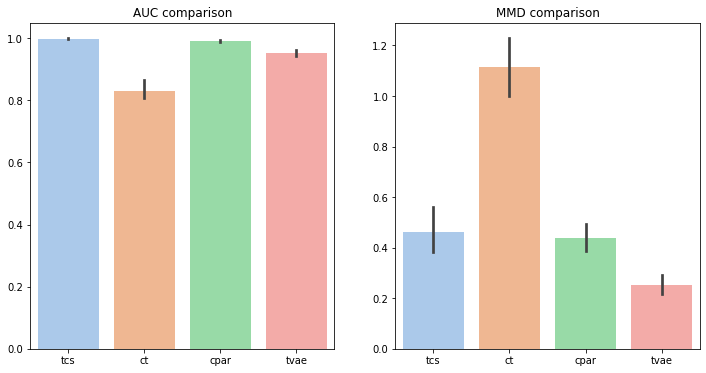

In [ ]:
# Load JSON
save_path = Path(os.getcwd()).parents[1] / "data" / "results" / "vs"

auc_dict = json.load(open(save_path / f"{FN}_auc.json", "r"))
mmd_dict = json.load(open(save_path / f"{FN}_mmd.json", "r"))
auc_df = pd.DataFrame(auc_dict).T
mmd_df = pd.DataFrame(mmd_dict).T

# Plot
f, axs = plt.subplots(ncols=2, figsize=(12, 6))
sns.barplot(data=auc_df, palette="pastel", ax=axs[0])
axs[0].set_title("AUC comparison")
sns.barplot(data=mmd_df, palette="pastel", ax=axs[1])
axs[1].set_title("MMD comparison")
plt.show()

### Notes

#### Helping code to create block-bootstraped versions of a large dataset 

In [ ]:
# # Parameters
# SET_LEN = 2000
# FN = "AirQualityUCI"

# # Path
# par_dir = Path(os.getcwd()).parents[1].as_posix() 
# target_path = f"{par_dir}/data/MvTS/{FN}"

# # Data
# original = pd.read_csv(target_path + f'/{FN}_original.csv')
# original = original.rename(columns=dict(zip(
#     original.columns, 
#     COL_NAMES
# )))

# # adjust timesteps for computation time (1500 max)
# print(f"true data length: {original.shape[0]}")
# if original.shape[0]>SET_LEN:
#     for b in range(20):
#         anchor = np.random.uniform(low=0, high=original.shape[0] - SET_LEN)
#         boot = original.loc[anchor : anchor + SET_LEN, :]
#         print(f"true data length (adjusted): {boot.shape[0]}")
#         boot.to_csv(target_path + f"/{FN}_boot_{b}.csv", index=False)